# Tutorial


In [1]:
%load_ext autoreload
%autoreload 2

import os
ROOT_DIR = os.getcwd()[:os.getcwd().rfind('NVcenter')]+ 'NVcenter'
os.chdir(ROOT_DIR)

from NVcenter import *
plt.style.use('NVcenter-default')

import numpy as np 
import matplotlib.pyplot as plt
import qutip as q

## Instantaneous Pulses vs. Continous Drive

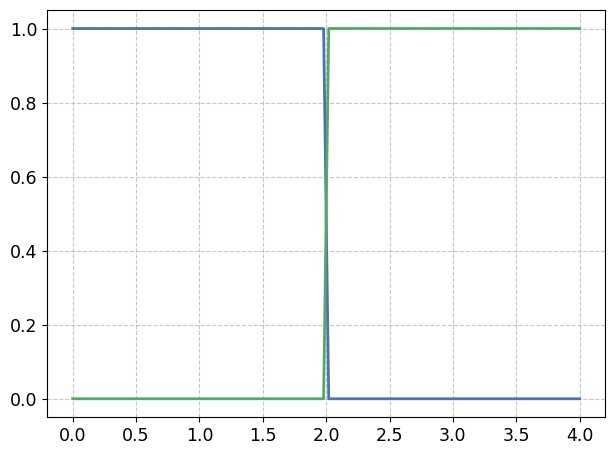

In [31]:
# instantaneous pulses

register_config = [('NV0', (0, 0, 0), 0, {})]
kwargs = dict(instant_pulses = True, verbose = False)

env = Environment(register_config, [], **kwargs)
pulse_seq = [2e-6, 2e-6, np.pi, 0]
t_list= np.linspace(0, 4e-6, 100)
new_register_states = env.get_new_register_states(pulse_seq, t_list=t_list)

fig, ax = plt.subplots()
ax.plot(t_list*1e6, [state[0,0].real for state in new_register_states])
ax.plot(t_list*1e6, [state[1,1].real for state in new_register_states])
plt.show()

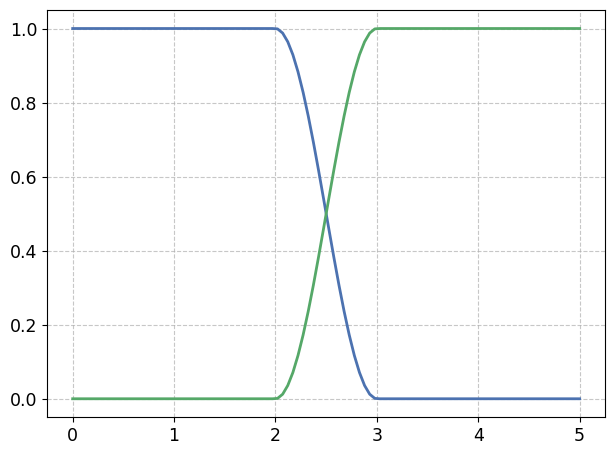

In [32]:
# continous drive (Rabi frequency 0.5 MHz, i.e., full rotation in 2 us)

# Note: use NV0 instead of NV for continous drive 
register_config = [('NV0', (0, 0, 0), 0, {})]
kwargs = dict(instant_pulses = False, verbose = False)

env = Environment(register_config, [], **kwargs)
pulse_seq = [2e-6, 2e-6, 1e-6, 0]
t_list=np.linspace(0, 5e-6, 100)
new_register_states = env.get_new_register_states(pulse_seq, t_list=t_list)

fig, ax = plt.subplots()
ax.plot(t_list*1e6, [state[0,0].real for state in new_register_states])
ax.plot(t_list*1e6, [state[1,1].real for state in new_register_states])
plt.show()

## Dynamical Decoupling and Hahn Echos

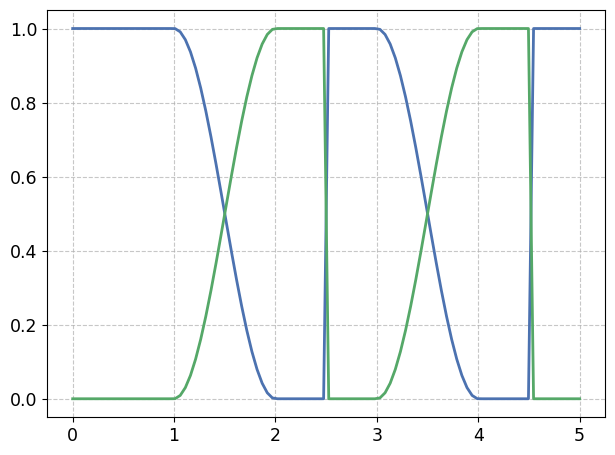

In [42]:
# dynamical decoupling

register_config = [('NV0', (0, 0, 0), 0, {})]
kwargs = dict(dynamical_decoupling = True, verbose = False)

env = Environment(register_config, [], **kwargs)
pulse_seq = [1e-6, 1e-6, 1e-6, 1e-6, 1e-6, 0, 0]
t_list= np.linspace(0, 5e-6, 100)
new_register_states = env.get_new_register_states(pulse_seq, t_list=t_list)

fig, ax = plt.subplots()
ax.plot(t_list*1e6, [state[0,0].real for state in new_register_states])
ax.plot(t_list*1e6, [state[1,1].real for state in new_register_states])
plt.show()

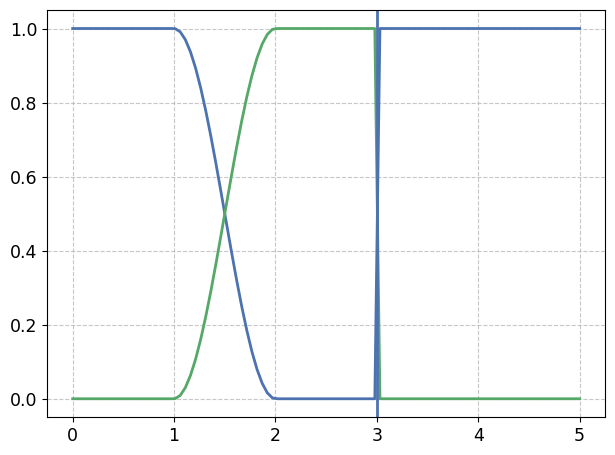

In [63]:
# Hahn echo (for even number nothing changes, for odd numbers the NV center is flipped because there is no inherent dynamics)

register_config = [('NV0', (0, 0, 0), 0, {})]
kwargs = dict(num_hahn_echos = 1, verbose = False)

env = Environment(register_config, [], **kwargs)
pulse_seq = [1e-6, 1e-6, 1e-6, 0]
t_list= np.linspace(0, 5e-6, 100)
new_register_states = env.get_new_register_states(pulse_seq, t_list=t_list)

fig, ax = plt.subplots()
ax.plot(t_list*1e6, [state[0,0].real for state in new_register_states])
ax.plot(t_list*1e6, [state[1,1].real for state in new_register_states])
ax.axvline(x=env.total_time*1e6)
plt.show()

## Suter Method

In [65]:
# with Suter method (factor 2pi)

C13_pos = (8.728883757198979e-10, 0.0, 1.8558998769620693e-10) # Dominik
# C13_pos = (8.713976612205478e-10, 0.0, 1.901805289026213e-10) # Suter (calculated using Suter's dipolar coupling strengths)
register_config = [('NV', (0, 0, 0), 0, {}), ('C13', C13_pos, 0, {})]
bath_configs = []

# Bell (Hadamard and CNOT)
init_state = q.tensor( q.fock_dm(2,0), q.fock_dm(2,0) )
bell_gate = get_cnot_gate(2, 0, 1) * get_hada_gate(2, 0)
bell_state = bell_gate * init_state * bell_gate.dag()

kwargs = dict(suter_method=True, instant_pulses=True, verbose=False, target=bell_state)

env = Environment(register_config, bath_configs, **kwargs)
pulse_seq = [0, 4.06620465e-6, 1.57022726e-6, 1.50788214e-6, 0.99813568, 3.57557112, 1.68300382, 0.69459264, 1.97327426, 0.50816523]
env.get_values(pulse_seq, 'fidelity', t_list='final')

[np.float64(0.9997793580086438)]

In [70]:
# without Suter method

C13_pos = (8.728883757198979e-10, 0.0, 1.8558998769620693e-10) # Dominik
C13_pos /= np.cbrt(np.pi*2) # 
register_config = [('NV', (0, 0, 0), 0, {}), ('C13', C13_pos, 0, {})]
bath_configs = []

# Bell (Hadamard and CNOT)
init_state = q.tensor( q.fock_dm(2,0), q.fock_dm(2,0) )
bell_gate = get_cnot_gate(2, 0, 1) * get_hada_gate(2, 0)
bell_state = bell_gate * init_state * bell_gate.dag()

kwargs = dict(suter_method=False, instant_pulses=True, verbose=False, target=bell_state)

env = Environment(register_config, bath_configs, **kwargs)
pulse_seq = [0, 4.06620465e-6, 1.57022726e-6, 1.50788214e-6, 0.99813568, 3.57557112, 1.68300382, 0.69459264, 1.97327426, 0.50816523]
env.get_values(pulse_seq, 'fidelity', t_list='final')

[np.float64(0.9997793580085619)]

## Thermal Bath

In [92]:
C13_pos = (8.728883757198979e-10, 0.0, 1.8558998769620693e-10) # Dominik
register_config = [('NV', (0, 0, 0), 0, {}), ('C13', C13_pos, 0, {})]
filename = os.path.join('NVcenter', 'data', 'dominik_bath')
directory = os.getcwd()

bath_configs_nested = load_spin_baths(filename, directory)
bath_configs = [item for sublist in bath_configs_nested for item in sublist]
bath_configs = [bath_config[:3] for bath_config in bath_configs][:10]

# Bell (Hadamard and CNOT)
init_state = q.tensor( q.fock_dm(2,0), q.fock_dm(2,0) )
bell_gate = get_cnot_gate(2, 0, 1) * get_hada_gate(2, 0)
bell_state = bell_gate * init_state * bell_gate.dag()

In [101]:
kwargs = dict(suter_method=True, instant_pulses=True, verbose=False, target=bell_state, env_approx_level='full_bath', thermal_bath=True)
env = Environment(register_config, bath_configs, **kwargs)

env.bath_config = env.bath_configs[0]
env.approx_level = env.env_approx_level
env.system_init_states[0].diag()

array([0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   ])

In [100]:
kwargs = dict(suter_method=True, instant_pulses=True, verbose=False, target=bell_state, env_approx_level='full_bath', thermal_bath=False)
env = Environment(register_config, bath_configs, **kwargs)

env.bath_config = env.bath_configs[0]
env.approx_level = env.env_approx_level
env.system_init_states[0].diag()

array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

## Flip the C13

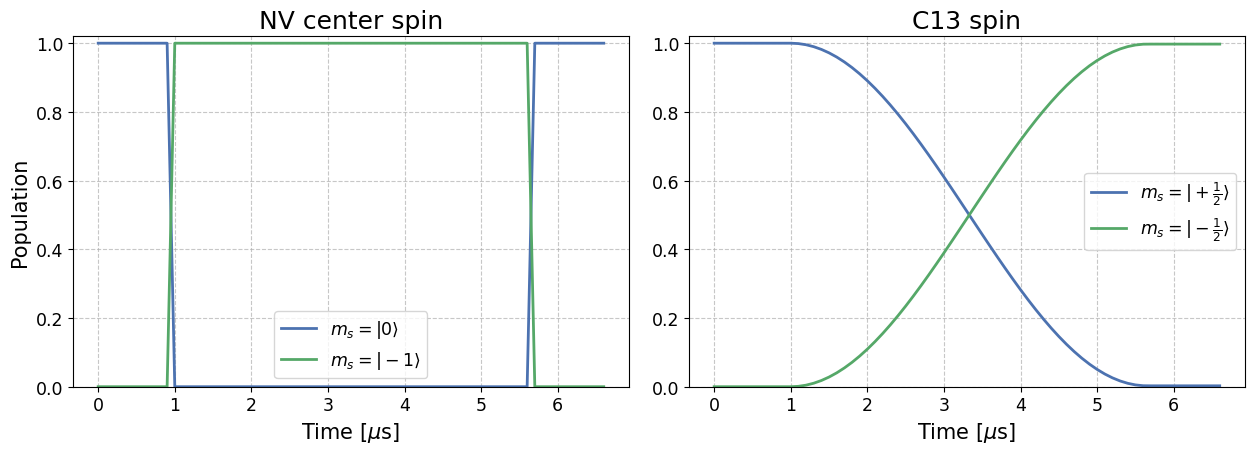

In [10]:
# pulse sequence to flip the C13 spin
kwargs = dict(suter_method=True, instant_pulses=True, verbose=False)
env = Environment(register_config, [], **kwargs)

matrix = env.calc_matrices()[0]
delta = matrix[2,3]
eps = matrix[3,3] - matrix[2,2]
T = np.pi/(2*np.pi*np.sqrt((delta**2 + eps**2)) ).real

pulse_seq = [1e-6, T/2, 1e-6, np.pi, np.pi, 0, 0]
t_list = np.arange(0, 2e-6+T/2, 0.1e-6)
new_states = env.get_new_register_states(pulse_seq, t_list=t_list)

fig, ax = plot_pops(t_list, new_states)

## Reliablity of the Cluster Expansion

In [11]:
import os

register_config = [('NV', (0, 0, 0), 0, {})]
filename = os.path.join('NVcenter', 'data', 'dominik_bath')
directory = os.getcwd()

# create and save a new spinbath
# spin_type, abundancy, rmin, rmax, num_baths, num_init_states = 'C13', 0.5e-2, 0, 4e-9, 2, 100
# save_spin_baths(filename, directory, spin_type, abundancy, rmin, rmax, num_baths, num_init_states)

bath_configs_nested = load_spin_baths(filename, directory)
bath_configs = [item for sublist in bath_configs_nested for item in sublist]

In [8]:
# Bell (Hadamard and CNOT)
init_state = q.tensor( q.fock_dm(2,0), q.fock_dm(2,0) )
bell_gate = get_cnot_gate(2, 0, 1) * get_hada_gate(2, 0)
bell_state = bell_gate * init_state * bell_gate.dag()

C13_pos = (8.728883757198979e-10, 0.0, 1.8558998769620693e-10) # Dominik
register_config = [('NV', (0, 0, 0), 0, {}), ('C13', C13_pos, 0, {})]

filename = os.path.join('NVcenter', 'data', 'dominik_bath')
directory = os.getcwd()
bath_configs_nested = load_spin_baths(filename, directory)
bath_configs = [item for sublist in bath_configs_nested for item in sublist]#[:10]
bath_configs = [bath_config[:5] for bath_config in bath_configs][:1]

env = Environment(register_config, bath_configs, verbose=True, suter_method=True, instant_pulses=True, target=bell_state, env_approx_level = 'gCCE2', parallelization=False, thermal_bath=False)
env.pulse_seq = [0, 4.06620465e-6, 1.57022726e-6, 1.50788214e-6, 0.99813568, 3.57557112, 1.68300382, 0.69459264, 1.97327426, 0.50816523]
t_list = np.linspace(env.total_time, 25e-6, 250)
log_negs_gCCE2 = env.get_values(env.pulse_seq, 'log_neg', t_list=t_list)

Calculating Hamiltonians for gCCE0: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 378.65it/s]


Time to calculate the Hamiltonians: 0.014380693435668945 s.



Calculating pulse matrices for gCCE0: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.36s/it]


Time to calculate the pulse matrices: 1.380366325378418 s.



Calculating new states for gCCE0: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.93it/s]


Time to calculate the new states: 1.4588873386383057 s.



Calculating Hamiltonians for gCCE1: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 361.80it/s]


Time to calculate the Hamiltonians: 0.03830313682556152 s.



Calculating pulse matrices for gCCE1: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.54s/it]


Time to calculate the pulse matrices: 7.736309051513672 s.



Calculating new states for gCCE1: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.76it/s]


Time to calculate the new states: 8.312649011611938 s.



Calculating Hamiltonians for gCCE2: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 212.26it/s]


Time to calculate the Hamiltonians: 0.04711127281188965 s.



Calculating pulse matrices for gCCE2: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:16<00:00,  1.69s/it]


Time to calculate the pulse matrices: 16.936311960220337 s.



Calculating new states for gCCE2: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.29it/s]


Time to calculate the new states: 18.154319763183594 s.


Calculating another bath configuration: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:28<00:00, 28.36s/it]

Elapsed time: 28.37806510925293 s


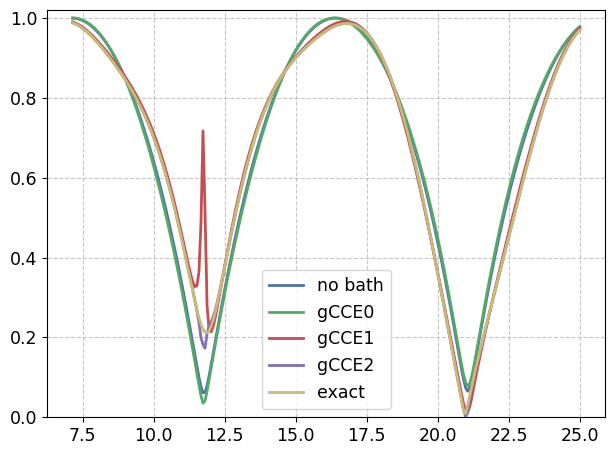

In [9]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot(t_list*1e6, log_negs_no_bath, label='no bath')
ax.plot(t_list*1e6, log_negs_gCCE0, label='gCCE0')
ax.plot(t_list*1e6, log_negs_gCCE1, label='gCCE1')
ax.plot(t_list*1e6, log_negs_gCCE2, label='gCCE2')
ax.plot(t_list*1e6, log_negs_full_bath, label='exact')
ax.legend()
ax.set_ylim(0,1.02)
plt.show()